# Surface Area From Location Drawing

## Load in Libraries

In [1]:
from scipy.spatial import Delaunay, KDTree
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
%matplotlib inline
import pandas as pd
import cv2
import math

# Load in Example Drawing Border

In [2]:
data = pd.read_csv("../Data/ExampleBoundaryTable.csv")
data.head()

,x,y
0,126,2125
1,127,2124
2,127,2123
3,127,2122
4,127,2121


## Load in Male Right Arm Mesh Data

In [3]:
imported_data =\
    np.load("../Data/male right arm mesh data.npz")
mesh_verticies = imported_data["mesh_verticies"]
mesh_faces = imported_data["mesh_faces"]

# Load in uv data
uv_array = imported_data["uv_array"]

# import the face data
face_data = pd.DataFrame(imported_data["face_data"],
                         columns=["vertex", "uv", "normal"])

## Define Function to Find UV vertex indicies

In [4]:
def find_uv_index_kdtree(border_points: pd.DataFrame, image_x_size: int,
                         image_y_size: int) -> int:
    '''
    Converts one location drawing border pixel to a UV value
    Takes a location drawing pixel location and converts it
    to the index the closest UV value to the pixel using a KD Tree
    Parameters
    ----------
    border_points: np.ndarray
    The x and y pixel values of a border point
    image_x_size: int
    The x dimension of the location drawing image in pixels
    image_y_size: int
    The y dimension of the location drawing image in pixels
    Returns
    -------
    indicies: int
    The row numbers of the closest uv to the 2D border point list
    '''
    data_array = border_points.to_numpy(dtype=float)
    data_array[:, 0] = data_array[:, 0] / image_x_size
    data_array[:, 1] = 1 - (data_array[:, 1] / image_y_size)
    _, indicies = KDTree(uv_array).query(data_array)
    return indicies

## Load in the Male Right Arm

In [5]:
# Find the image dimensions
img = cv2.imread('../Media/right arm.png', 1)
image_x_size = img.shape[1]
image_y_size = img.shape[0]
print(image_x_size)

1942


## Convert the Boundary Pixel Values to Their Corresponding Indicies in the UV Array

### Compare Finding the Nearest Point Using a KDTree
A KDTree divides the points to search over into regions and then does a binary search to find the closest point.

In [6]:
kd_tree_uv_indicies = find_uv_index_kdtree(data, image_x_size, image_y_size)

### The KD Tree is Much Much Faster

In [7]:
boundary_uv_array = kd_tree_uv_indicies

### Delete Duplicate UV Array Indicies

In [8]:
print(f"Before deleteing duplicates, there were {len(boundary_uv_array)} uv points in the border")
cleaned_boundary_uv_array = []
[cleaned_boundary_uv_array.append(x) for x in boundary_uv_array if x not in cleaned_boundary_uv_array]
print(f"After deleteing duplicates, there were {len(cleaned_boundary_uv_array)} uv points in the border")
print(f"This is a reducation to {len(cleaned_boundary_uv_array) / len(boundary_uv_array) * 100}% of points in the path.")

Before deleteing duplicates, there were 3441 uv points in the border
After deleteing duplicates, there were 584 uv points in the border
This is a reducation to 16.971810520197618% of points in the path.


## Check the Original Boundary vs The UV Boundaries

Text(0.5, 1.0, 'Original Boundary')

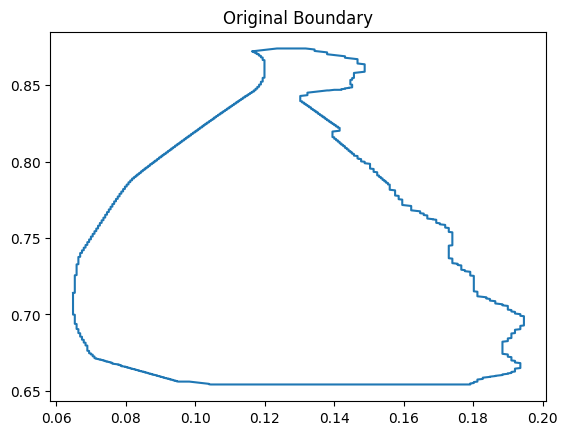

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(data["x"] / image_x_size, 1 - data["y"] / image_y_size)
plt.title("Original Boundary")

Text(0.5, 1.0, 'UV Boundary with Duplicates')

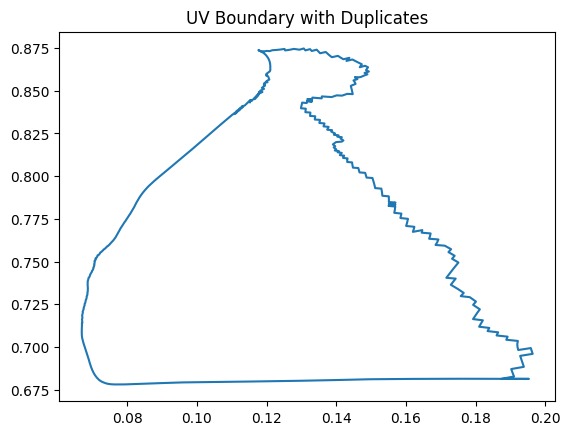

In [10]:
path = uv_array[boundary_uv_array]
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(path[:, 0], path[:, 1])
plt.title("UV Boundary with Duplicates")

Text(0.5, 1.0, 'UV Boundary without Duplicates')

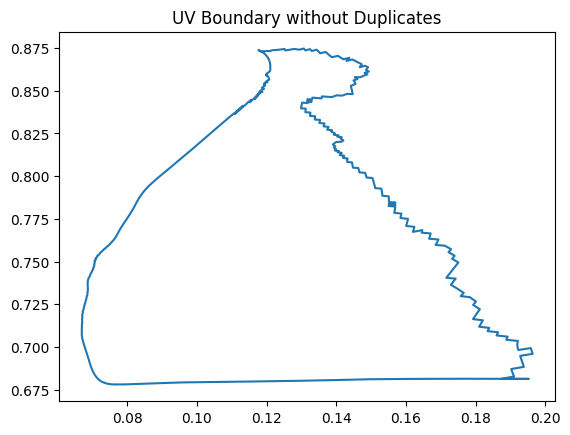

In [11]:
path = uv_array[cleaned_boundary_uv_array]
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(path[:, 0], path[:, 1])
plt.title("UV Boundary without Duplicates")

## Find the UV Points Inside the UV Boundary

In [12]:
boundary = mpltPath.Path(path)
inside_boundary = boundary.contains_points(uv_array)

### Visualize the Points that were Found

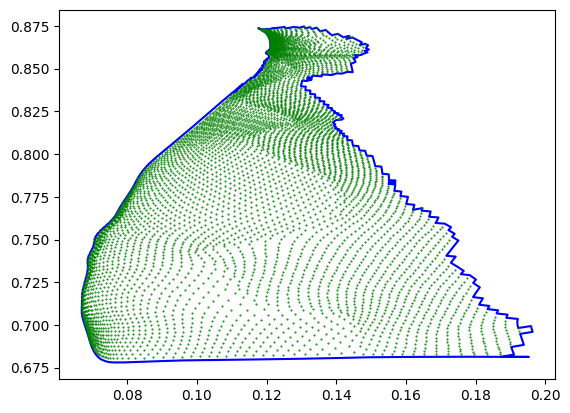

In [13]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(path[:, 0], path[:, 1], 'b-')
ax.plot(uv_array[inside_boundary, 0], uv_array[inside_boundary, 1], 'g.',
markersize=1)

### Check the Location on the Full UV Map

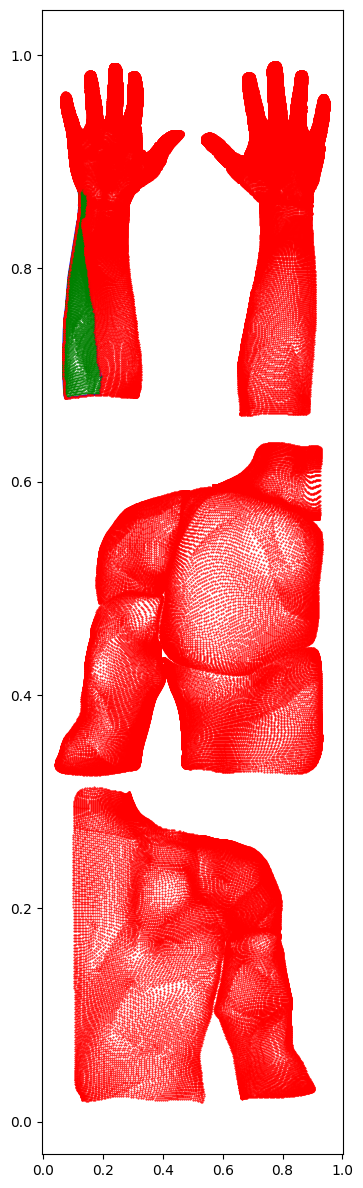

In [14]:
fig = plt.figure(figsize=(image_x_size/500, image_y_size/500))
ax = fig.add_subplot()
ax.plot(path[:, 0], path[:, 1], 'b-', markersize=2)
ax.plot(uv_array[inside_boundary, 0], uv_array[inside_boundary, 1], 'g.', markersize=1)
ax.plot(uv_array[np.invert(inside_boundary), 0],
        uv_array[np.invert(inside_boundary), 1], 'r.', markersize=1)

## Triangluate the Found Mesh
This is so we can apply the same triangulation to the 3D mesh

In [15]:
inside_boundary_ids = [i for i, x in enumerate(inside_boundary) if x]
combined_uv_array = cleaned_boundary_uv_array.copy()
combined_uv_array.extend(inside_boundary_ids)

combined_uv_array_unique = []
[combined_uv_array_unique.append(x) for x in combined_uv_array if x not in combined_uv_array_unique]

combined_uv_array = np.array(combined_uv_array_unique)
location_uvs = np.array(uv_array[combined_uv_array])
triangulated_uvs = Delaunay(location_uvs)
print(f"There are {len(location_uvs)} uv points to triangulate between.")

There are 6597 uv points to triangulate between.


### Visulatize the Triangulation

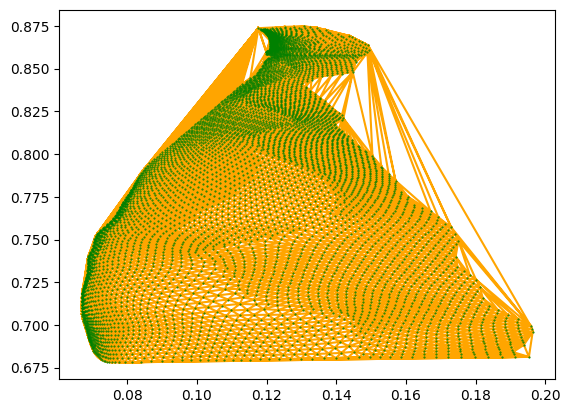

In [16]:
fig = plt.figure()
plt.triplot(location_uvs[:,0], location_uvs[:,1], triangulated_uvs.simplices,c='orange')
plt.plot(location_uvs[:,0], location_uvs[:,1], 'g.', markersize=1)

### Eliminate Triangles that Only Connect to Border Points

In [17]:
highest_boundary_index = len(combined_uv_array) - len(inside_boundary_ids)
triangles = np.array(triangulated_uvs.simplices)
reduced_triangles = []
for row in triangles:
    if not np.all(row <= highest_boundary_index):
        reduced_triangles.append(row)
print(f"Before eliminating border triangles, there were {len(triangles)} triangles.")
print(f"After eliminating border triangles, there were {len(reduced_triangles)} triangles.")
reduced_triangles = np.array(reduced_triangles)

Before eliminating border triangles, there were 13142 triangles.
After eliminating border triangles, there were 12574 triangles.


#### Visualize the Reduced Triangulation

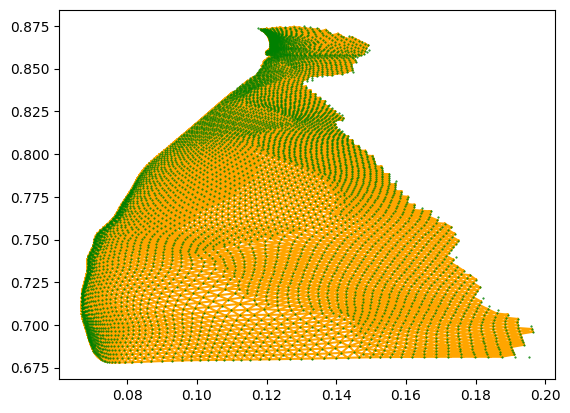

In [18]:
fig = plt.figure()
plt.triplot(location_uvs[:,0], location_uvs[:,1], reduced_triangles, c='orange')
plt.plot(location_uvs[:,0], location_uvs[:,1], 'g.', markersize=1)

## Translate the UV Triangulation to the 3D Mesh

### Find the Indicies of the Verticies from the UV Indicies

### Sort the UV Indicies

In [19]:
indicies_of_sorted_indicies = np.argsort(combined_uv_array)
sorted_indicies = combined_uv_array[indicies_of_sorted_indicies]

In [20]:
face_data_reduced = face_data[["vertex", "uv"]].drop_duplicates()
face_data_reduced = face_data_reduced.sort_values(by=['uv'])

### Find all Verticies at Once and Reorganize the Array Based on the Sort

In [21]:
face_data_reduced[face_data_reduced['uv'].isin(combined_uv_array)]

sorted_vertex_ids = face_data_reduced[face_data_reduced['uv'].isin(combined_uv_array)]["vertex"].to_numpy()

vertex_ids = np.empty((len(combined_uv_array))).astype(int)

for index, value in enumerate(indicies_of_sorted_indicies):
    vertex_ids[value] = sorted_vertex_ids[index]

### Get the Vertex Positions using the Indicies

In [22]:
location_surface = np.array(mesh_verticies[vertex_ids])

### Check that the Shape of the Array is Correct (6630x3)

In [23]:
print(f"The shape of the array is {location_surface.shape}")

The shape of the array is (6597, 3)


### Show the Verticies in 3D

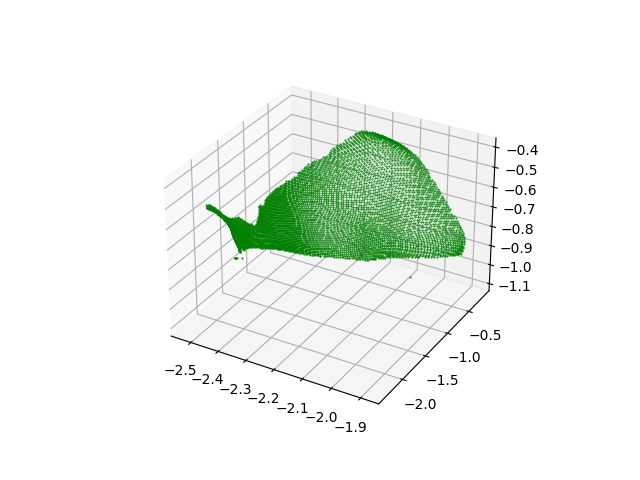

In [24]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(location_surface[:, 0], location_surface[:, 1],
        location_surface[:, 2], 'g.', markersize=1)

## Show the Triangulation on the Mesh

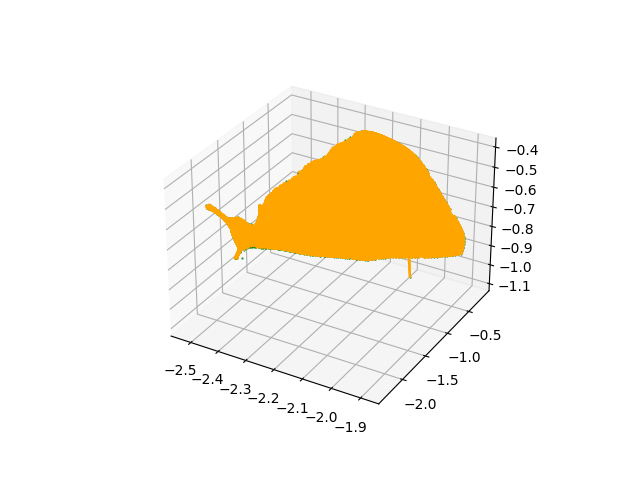

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(location_surface[:, 0], location_surface[:, 1],
        location_surface[:, 2], 'g.', markersize=1)

for tri in reduced_triangles:
    ax.plot(location_surface[tri, 0], location_surface[tri, 1],
            location_surface[tri, 2], c='orange', markersize=1)

## Find the Surface Area of the 3D Location Drawing

### Heron's Formula

Given any triangle with sides of length a, b, and c: The area is:
$$A=\sqrt{s(s-a)(s-b)(s-c)}$$
Where:
$$s=\frac{a+b+c}{2}$$

### Define Heron's Formula in Code

In [26]:
def heron_area(p1, p2, p3):
    a = np.linalg.norm(p1 - p2)
    b = np.linalg.norm(p2 - p3)
    c = np.linalg.norm(p1 - p3)
    s = (a + b + c) / 2
    return math.sqrt(s * (s - a) * (s - b) * (s - c))

### Calculate the Area Using Heron's Formula

In [27]:
area_array = np.array([])
for tri in reduced_triangles:
    p1 = location_surface[tri[0]]
    p2 = location_surface[tri[1]]
    p3 = location_surface[tri[2]]
    area_array = np.append(area_array, heron_area(p1, p2, p3))
    
print(f"The area of the drawn location is {np.sum(area_array)} scene units")

The area of the drawn location is 1.0903241951256168 scene units


## Eliminate Outlier Triangle Areas
These areas are from making triangles to points that are on the other side of the mesh and make much larger triangles

In [28]:
def remove_outliers(data: np.ndarray, deviations: int = 3) -> np.ndarray:
    '''
    Remove outliers using the distance away from the median

    The median is a more robust measure compared to the mean as the mean is
    biased by outliers. The median absolute deviation is also a substitute for
    the standard deviation when using the median.

    Parameters
    ----------
    data: np.ndarray
    The areas of all of the calculated triangles
    deviations: int
    The number of deviations away from the median to use as an outlier

    Returns
    -------
    cleaned_data: np.ndarray
    The data with outliers removed
    '''
    distance_from_median = np.abs(data - np.median(data))
    # find the median absolute deviate (similar to standard deviation)
    median_absolute_deviation = np.median(distance_from_median)
    if median_absolute_deviation > 0:
        deviations_away_from_median =\
            distance_from_median / median_absolute_deviation
    else:
        deviations_away_from_median = np.zeros(len(distance_from_median))

    cleaned_data = data[deviations_away_from_median < deviations]
    return (cleaned_data, deviations_away_from_median)


In [29]:
deviations = 75
cleaned_area_array, deviations_away_from_median = remove_outliers(area_array, deviations)
print(f"{len(area_array) - len(cleaned_area_array)} triangles were removed")

11 triangles were removed


### Show the updated area

In [30]:
print(f"The area of the drawn location is actually {np.sum(cleaned_area_array)} scene units")

The area of the drawn location is actually 0.9157284617701242 scene units


Text(0.5, 0.92, '75 Deviations as Outlier (area=0.9157284617701242)')

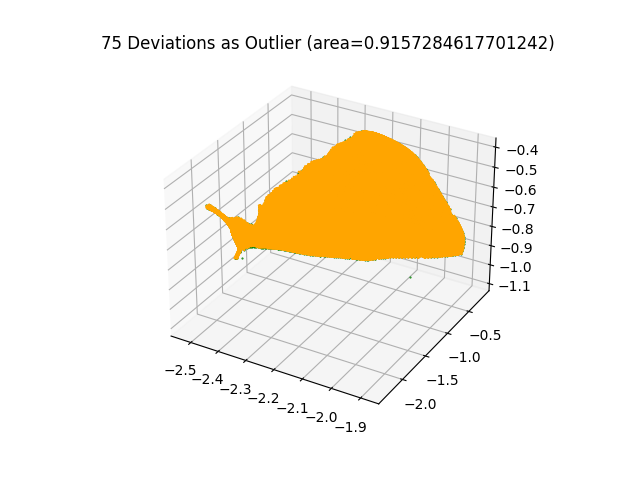

In [31]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(location_surface[:, 0], location_surface[:, 1],
        location_surface[:, 2], 'g.', markersize=1)

for tri in reduced_triangles[deviations_away_from_median < deviations]:
    ax.plot(location_surface[tri, 0], location_surface[tri, 1],
            location_surface[tri, 2], c='orange', markersize=1)
    
plt.title(f"{deviations} Deviations as Outlier (area={np.sum(cleaned_area_array)})")